#Reconocimiento de ciervos
Realizado por:
* Isabela Luján Jaramillo 
* Daniel Alexander Naranjo Ríos

## Instalar TensorFlow y keras

---
Primero instalamos tensorflow y keras en python.


In [ ]:
!pip install -q tensorflow
!pip install -q keras-tuner

## Conexión con Google Drive

---
Ahora hacemos la conexión con Google Drive, que es donde tenemos guardado el dataset de los ciervos.


In [ ]:
carpeta_dataset = 'https://drive.google.com/drive/folders/1e-0-q-DtNYcWqWlL-P8QrAuXwu6KlWav?usp=sharing' #@param ["https://drive.google.com/drive/folders/1e-0-q-DtNYcWqWlL-P8QrAuXwu6KlWav?usp=sharing"]
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importar librerías

---
Importamos todas las librerías necesarias para la ejecución del programa.


In [ ]:
import tensorflow as tf # Biblioteca de código abierto para aprendizaje automático

# Importar Keras - es un complento para tensorflow para el entrenamiento de la red neuronal
import keras 
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from kerastuner.tuners import RandomSearch

# Para el cálculo de métricas
from sklearn.metrics import accuracy_score, recall_score, precision_score

import plotly.graph_objects as go # Para la matriz de confusión
import pandas as pd  # Para calculos matemáticos y estadísticos
import numpy as np  # Para la creación de matrices

import matplotlib.pyplot as plt # Para graficar
import matplotlib.image as mpimg

import os  # Para recorrer las direcciones de los archivos
import cv2  # Para la modificación de imágenes
import random  # Para generar valores aleatorios

## Paths

---
Creación de variables con las direcciones de los archivos que vamos a necesitar.


In [ ]:
# Path en google drive de la carpeta con el dataset
data_path = '/content/drive/Shared drives/Inteligencia Artificial - Microproyectos/Microproyecto 2/'

train_path = data_path + "DeerDataset/train/"
test_path = data_path + "DeerDataset/test/"

categories = ["Doe", "Buck", "Fawn", "Herd"]
spanish = ["Hembra", "Macho", "Cervatillo", "Manada"]

## Función para preprocesar la imagen

---
Cambiamos el tamaño, color y dimensión de la imagen. La imagen se guarda en escala de grises porque luego de hacer pruebas notamos que el color no influye en el desempeño.


In [ ]:
SIZE=200
def preprocess_image(img):
  min_side = min(img.shape[0], img.shape[1])
  img = img[:min_side, :min_side]
  img = cv2.resize(img, (SIZE,SIZE)) #Cambiar el tamaño de la imagen
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Poner la imagen en escala de grises
  return img / 255.0 #Normalizar para trabajar antre 0 y 1

## Cargar imágenes y etiquetarlas numéricamente

---
Hacemos un loop para recorrer la carpeta de las imágenes de entrenamiento y las imágenes de prueba, en cada paso se entra a la subcarpeta con cada categoría, dentro de la carpeta se saca el nombre de cada imagen para luego llamar a la función de preprocesado de la imagen y luego se guarda en un arreglo junto con su etiqueta correspondiente. Los arreglos de entrenamiento y prueba quedan ordenados, lo que podría crear un sesgo para la predicción en base al orden, debido a esto desordenamos ambos arreglos.




---
*Datos de entrenamiento*


In [ ]:
# Inicializar variable para los datos de entrenamiento
training_data = []

# Creación de arreglo con las imágenes de entrenamiento
for category in categories:

  category_path = train_path + category  #Path a cada categoría
  num_label = categories.index(category)  #Definir etiqueta numérica con el index de la categoría

  for img in os.listdir(category_path):

    img_array = cv2.imread(category_path + "/" + img)  #Convertir a arreglo
    new_array = preprocess_image(img_array)
    training_data.append([new_array, num_label]) #Arreglo con la imagen y si etiqueta

#Desordenar los datos
random.shuffle(training_data) 

print(len(training_data))

1349




---
*Datos de prueba*


In [ ]:
# Inicializar variable para los datos de prueba
testing_data = []

# Creación de arreglo con las imágenes de prueba
for category in categories:

  category_path = test_path + category #Path a cada categoría
  num_label = categories.index(category)  #Definir etiqueta numérica con el index de la categoría
  for img in os.listdir(category_path):

    img_array = cv2.imread(category_path + "/" + img)  #Convertir a arreglo
    new_array = preprocess_image(img_array)
    testing_data.append([new_array, num_label]) #Arreglo con la imagen y su etiqueta

#Desordenar los datos
random.shuffle(testing_data)

print(len(testing_data))

143


## Modelo definitivo

---
En este paso se separa cada arreglo en dos, uno con las imágenes y otro con las etiquetas, quedan 4 arreglos en total, luego los ponemos en formato np.array para poderlos usar con las libreías de keras y tensorflow.




---
*Datos de entrenamiento*

In [ ]:
# Creación de los areglos de las imágenes de entrenamiento
train_images_temp = []
train_labels_temp = []

# Creación de dos arreglos tiop numpy array uno con las imágenes y otro con las 
# etiquetas para los datos de entrenamiento
for images, label in training_data:
    train_images_temp.append(images)
    train_labels_temp.append(label)

train_images = np.array(train_images_temp).reshape(-1, SIZE, SIZE, 1)
train_labels = np.array(train_labels_temp)
train_images.shape

(1349, 200, 200, 1)



---
*Datos de prueba*

In [ ]:
# Creación de los areglos de las imágenes de prueba
test_images_temp = []
test_labels_temp = []

# Creación de dos arreglos tipo numpy array uno con las imágenes y otro con las 
# etiquetas para los datos de prueba
for images, label in testing_data:
    test_images_temp.append(images)
    test_labels_temp.append(label)

test_images = np.array(test_images_temp).reshape(-1, SIZE, SIZE, 1)
test_labels = np.array(test_labels_temp)
test_images.shape

(143, 200, 200, 1)

## Creación del modelo y ajuste de los parametros

---
A continuación, se procede crear el modelo y recalcular algunos parametros haciendo uso de la herramienta keras tunner.



In [ ]:
#Primero se defina un modelo normal para la red neuronal
model = keras.Sequential([
keras.layers.Conv2D(64, 3, padding='same', input_shape=train_images.shape[1:], activation='relu'),
keras.layers.Conv2D(32, 3, padding='same', input_shape=train_images.shape[1:], activation='relu'),
keras.layers.MaxPool2D(pool_size=(2, 2)),
keras.layers.Dense(3, activation='relu'),
keras.layers.Dropout(0.5),
keras.layers.Flatten(),
keras.layers.Dense(32, activation='softmax')])
model.compile(optimizer='adam',
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_images, 
    train_labels, 
    batch_size = 50,
    epochs = 20,
    validation_data = (test_images, test_labels)
)

Epoch 1/20
27/27 [==============================] - 6s 223ms/step - loss: 1.5485 - accuracy: 0.2965 - val_loss: 1.4387 - val_accuracy: 0.2937
Epoch 2/20
27/27 [==============================] - 4s 155ms/step - loss: 1.3789 - accuracy: 0.3188 - val_loss: 1.3583 - val_accuracy: 0.3217
Epoch 3/20
27/27 [==============================] - 4s 153ms/step - loss: 1.3597 - accuracy: 0.3440 - val_loss: 1.3431 - val_accuracy: 0.3497
Epoch 4/20
27/27 [==============================] - 4s 155ms/step - loss: 1.3304 - accuracy: 0.3462 - val_loss: 1.3144 - val_accuracy: 0.4056
Epoch 5/20
27/27 [==============================] - 4s 154ms/step - loss: 1.2532 - accuracy: 0.4233 - val_loss: 1.3205 - val_accuracy: 0.4615
Epoch 6/20
27/27 [==============================] - 4s 155ms/step - loss: 1.0880 - accuracy: 0.5419 - val_loss: 1.1763 - val_accuracy: 0.4755
Epoch 7/20
27/27 [==============================] - 4s 155ms/step - loss: 0.8458 - accuracy: 0.6723 - val_loss: 1.1415 - val_accuracy: 0.5385
Epoch 

##Gráficas para visualizar la evolución del desempeño del modelo inicial

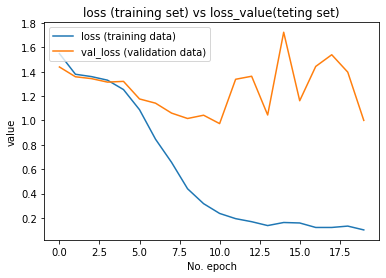

In [ ]:
#Gráfica de la función pérdida y la pérdida entrecruzada:

plt.plot(history.history['loss'], label='loss (training data)')
plt.plot(history.history['val_loss'], label='val_loss (validation data)')
plt.title('loss (training set) vs loss_value(teting set)')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

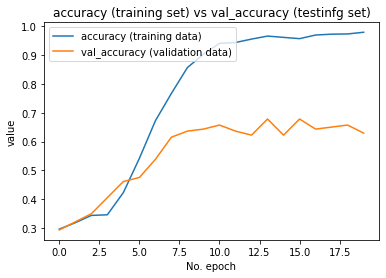

In [ ]:
#Gráfica de la exactitud de entrenamiento y la de evaluación

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='val_accuracy (validation data)')
plt.title('accuracy (training set) vs val_accuracy (testinfg set)')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

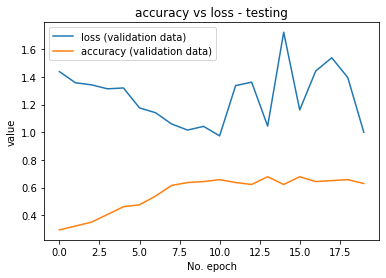

In [ ]:
#Gráfica de la exactitud de entrenamiento vs la perdida en el set de testing

import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'], label='loss (validation data)')
plt.plot(history.history['val_accuracy'], label='accuracy (validation data)')
plt.title('accuracy vs loss - testing')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

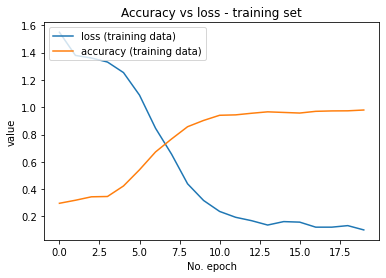

In [ ]:
#Gráfica de la exactitud de entrenamiento vs la perdida en el set de training

import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss (training data)')
plt.plot(history.history['accuracy'], label='accuracy (training data)')
plt.title('Accuracy vs loss - training set')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

##Recalcular algunos parametros usando keras tuner


---
A continuación se le hacen algunos cambios al modelo anterior para que sea apto para el uso de la herramienta keras-tuner.


In [ ]:
def build_model(hp):
  model = keras.Sequential([
  keras.layers.Conv2D(64, 3, padding='same', input_shape=train_images.shape[1:], activation='relu'),
  keras.layers.Conv2D(32, 3, padding='same', input_shape=train_images.shape[1:], activation='relu'),
  keras.layers.MaxPool2D(pool_size=(2, 2)),
  keras.layers.Dense(3, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Flatten(),
  keras.layers.Dense(hp.Choice("Dense layer", [32, 128, 512]), activation='softmax')]) # Se le da a la herramienta un grupo de valores para asignarle a la catidad de filtros de esta capa
  model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

  return model

tuner = RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=5,
    overwrite=True,
)

## Entrenamiento de la red neuronal

---
Se establecen los parámetros del entrenamiento con x iteraciones y se entrena la red neuronal con el modelo establecido.
Para asegurar el mejor desempeño posible de la red neuronal se usa la herramienta keras tuner para hallar los hiperparametros que arrojen mejores resultados.


In [ ]:
tuner.search(
    train_images, 
    train_labels, 
    validation_data = (test_images, test_labels), 
    epochs=20, 
    batch_size=32
)

Epoch 1/20
43/43 [==============================] - 5s 123ms/step - loss: 1.6538 - accuracy: 0.2669 - val_loss: 1.3645 - val_accuracy: 0.3147
Epoch 2/20
43/43 [==============================] - 5s 112ms/step - loss: 1.3748 - accuracy: 0.3121 - val_loss: 1.3486 - val_accuracy: 0.3287
Epoch 3/20
43/43 [==============================] - 5s 114ms/step - loss: 1.3543 - accuracy: 0.3484 - val_loss: 1.3508 - val_accuracy: 0.3497
Epoch 4/20
43/43 [==============================] - 4s 103ms/step - loss: 1.3593 - accuracy: 0.3425 - val_loss: 1.4013 - val_accuracy: 0.3077
Epoch 5/20
43/43 [==============================] - 4s 104ms/step - loss: 1.3905 - accuracy: 0.3173 - val_loss: 1.3576 - val_accuracy: 0.3147
Epoch 6/20
43/43 [==============================] - 4s 104ms/step - loss: 1.3405 - accuracy: 0.3328 - val_loss: 1.3270 - val_accuracy: 0.3427
Epoch 7/20
43/43 [==============================] - 5s 113ms/step - loss: 1.3284 - accuracy: 0.3580 - val_loss: 1.3019 - val_accuracy: 0.3916
Epoch 

Epoch 1/20
43/43 [==============================] - 4s 102ms/step - loss: 1.5339 - accuracy: 0.2876 - val_loss: 1.4180 - val_accuracy: 0.3287
Epoch 2/20
43/43 [==============================] - 4s 100ms/step - loss: 1.3558 - accuracy: 0.3358 - val_loss: 1.3287 - val_accuracy: 0.3986
Epoch 3/20
43/43 [==============================] - 4s 100ms/step - loss: 1.2029 - accuracy: 0.4648 - val_loss: 1.1732 - val_accuracy: 0.5175
Epoch 4/20
43/43 [==============================] - 4s 100ms/step - loss: 0.8838 - accuracy: 0.6612 - val_loss: 0.9918 - val_accuracy: 0.5874
Epoch 5/20
43/43 [==============================] - 4s 100ms/step - loss: 0.5211 - accuracy: 0.8228 - val_loss: 0.8724 - val_accuracy: 0.6503
Epoch 6/20
43/43 [==============================] - 4s 100ms/step - loss: 0.3549 - accuracy: 0.8940 - val_loss: 0.9287 - val_accuracy: 0.6853
Epoch 7/20
43/43 [==============================] - 4s 98ms/step - loss: 0.2820 - accuracy: 0.9170 - val_loss: 1.0407 - val_accuracy: 0.6643
Epoch 8

Epoch 1/20
43/43 [==============================] - 5s 105ms/step - loss: 1.7145 - accuracy: 0.2847 - val_loss: 1.3590 - val_accuracy: 0.3147
Epoch 2/20
43/43 [==============================] - 4s 102ms/step - loss: 1.3669 - accuracy: 0.3047 - val_loss: 1.3530 - val_accuracy: 0.3497
Epoch 3/20
43/43 [==============================] - 4s 102ms/step - loss: 1.3590 - accuracy: 0.3299 - val_loss: 1.3626 - val_accuracy: 0.3077
Epoch 4/20
43/43 [==============================] - 4s 103ms/step - loss: 1.3642 - accuracy: 0.3403 - val_loss: 1.4841 - val_accuracy: 0.3357
Epoch 5/20
43/43 [==============================] - 4s 101ms/step - loss: 1.3595 - accuracy: 0.3529 - val_loss: 1.3185 - val_accuracy: 0.3776
Epoch 6/20
43/43 [==============================] - 4s 103ms/step - loss: 1.2744 - accuracy: 0.4211 - val_loss: 1.1945 - val_accuracy: 0.4965
Epoch 7/20
43/43 [==============================] - 4s 104ms/step - loss: 0.9291 - accuracy: 0.6323 - val_loss: 1.0101 - val_accuracy: 0.6014
Epoch 

INFO:tensorflow:Oracle triggered exit


A continuación se seleccionan los hiperparametros que dieron mejores resultados y se guardan en la variable *best_model* para luego evaluar el desempeño final del modelo.

In [ ]:
best_model = tuner.get_best_models()[0]

# Calculo del desempeño final del modelo ajustado

In [ ]:
best_model.evaluate(test_images, test_labels)

5/5 [==============================] - 0s 25ms/step - loss: 1.3471 - accuracy: 0.6434


[1.3470957279205322, 0.6433566212654114]

##Fallos cometidos

---
Se imprime una comparación de la predicción de la red con los valores reales primero con los arreglos de las etiquetas numéricas y luego con las etiquetas literales.



In [ ]:
predictions = np.array(best_model.predict(test_images).argmax(axis=1))
print("Predicciones hechas: \n",predictions, '\n')
print("Respuestas correctas: \n", test_labels)

cont_fawn=0
cont_herd=0
cont_buck=0
cont_doe=0

for i in range (len(predictions)):
  if (predictions[i] != test_labels[i]):
    predicted=categories[predictions[i]]
    real=categories[test_labels[i]]
    if (real=="Buck"):
      cont_buck+=1
    elif (real=="Doe"):
      cont_doe+=1
    elif (real=="Fawn"):
      cont_fawn+=1
    else:
      cont_herd+=1

print("\nVeces en las que el modelo falló en identificar cada categoria:")
print("Hembras: ",cont_doe)
print("Machos: ", cont_buck)
print("Cervatos: ", cont_fawn)
print("Grupos: ",cont_herd)

Predicciones hechas: 
 [2 0 0 1 2 0 0 1 3 2 1 2 3 2 2 1 2 1 2 1 0 2 0 1 1 1 2 1 1 2 1 1 1 1 0 0 3
 1 1 2 0 0 3 1 2 1 1 2 2 0 1 2 1 1 2 3 2 0 2 1 2 1 0 1 2 2 1 1 0 0 0 3 0 2
 1 2 0 1 0 1 2 3 1 1 2 0 1 2 1 1 1 1 2 2 0 2 1 2 1 2 3 1 2 2 0 2 2 2 2 0 0
 2 1 1 2 0 2 2 3 1 1 2 1 2 2 1 0 2 2 1 0 1 1 1 1 1 2 3 1 2 2 0 1] 

Respuestas correctas: 
 [2 2 0 3 0 0 2 1 2 2 1 1 3 0 0 3 2 3 0 2 0 3 2 1 3 1 2 1 1 2 1 1 3 2 0 0 3
 1 2 0 0 0 3 1 0 1 1 2 0 0 1 2 1 1 0 3 2 2 3 1 0 1 2 1 2 0 1 1 0 0 0 3 0 2
 1 3 3 1 2 1 0 2 1 1 3 2 1 2 1 1 1 1 2 2 3 2 1 3 3 2 3 3 2 2 0 2 3 0 2 0 0
 2 1 1 3 2 2 3 3 2 1 2 1 3 2 1 2 0 1 1 2 1 1 1 1 0 2 3 1 2 2 1 1]

Veces en las que el modelo falló en identificar cada categoria:
Hembras:  14
Machos:  3
Cervatos:  16
Grupos:  18


## Matriz de confusión

---
Con la librería pandas se genera una tabla que muestra en las filas las predicciones que hizo la CNN con su respectiva etiqueta numérica y en las columnas los valores reales con su respectiva etiqueta numérica, también se imprimen las etiquetas alfabéticas de cada etiqueta numérica.

In [ ]:
print("0 = Doe (Hembra) \n" +
"1 = Buck (Macho) \n" +
"2 = Fawn (Cervato) \n" +
"3 = Herd (Grupo) \n")

df_confusion = pd.crosstab(predictions, test_labels, colnames=["Reales"], rownames=["Predicciones"])
df_confusion

0 = Doe (Hembra) 
1 = Buck (Macho) 
2 = Fawn (Cervato) 
3 = Herd (Grupo) 



Reales,0,1,2,3
Predicciones,,,,
0,15,1,10,2
1,1,43,4,7
2,13,2,26,9
3,0,0,2,8


## Cálculo de métricas

---
Con ayuda de sklearn.metrics se calculan las métricas de desempeño de la red neuronal.




In [ ]:
# Accuracy
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy score:",accuracy)

# Recall
recall = recall_score(test_labels, predictions, average='weighted')
print("Recall: ",recall)

# Precision
precision = precision_score(test_labels, predictions, average='weighted')
print("Precision: ", precision)

#F1-Score
f1_score = (2 * precision * recall) / (precision + recall)
print("F1-Score: ", f1_score)

Accuracy score: 0.6433566433566433
Recall:  0.6433566433566433
Precision:  0.6583171374080464
F1-Score:  0.6507509178500677


## Prueba de etiquetado de una imagen

---
Primero se crea un nuevo arreglo con los datos de prueba de dimensiones (x, SIZE, SIZE) para que pueda se usado con las funciones plot, luego se ingresa un valor *num_img* que pertenece a la posición de la imagen en el arreglo de las imágenes de prueba para luego mostrarla y mostrar como lo etiquetó la CNN y compararla con la etiqueta real.






---
*Prueba de una sola imagen dentro del dataset de pruebas*


In [ ]:
# Mostrar la imagen, la predicción y la etiqueta real
num_img = 9
print("La CNN predice que es:", categories[predictions[num_img]], "=", spanish[predictions[num_img]])
print("La imagen está etiquetada como:", categories[test_labels[num_img]], "=", spanish[test_labels[num_img]])
print("\n--------------------------------------------- \n")

if (predictions[num_img] == test_labels[num_img]):
  print("La CNN acertó")
else:
  print("La CNN falló")

La CNN predice que es: Fawn = Cervatillo
La imagen está etiquetada como: Fawn = Cervatillo

--------------------------------------------- 

La CNN acertó




---
*Prueba de una sola imagen ingresada por el usuario*

La CNN con keras predice que es un Doe o Hembra en español
La CNN sin keras predice que es un Doe o Hembra en español


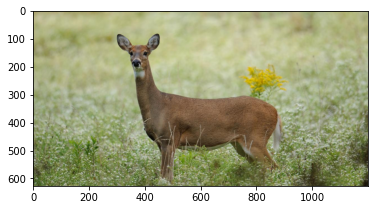

In [ ]:
#La CNN no está entrenada para reconocer objetos o seres diferentes a los ciervos
image_title = "Cosa4.jpg"
user_image_og = data_path + "DeerDataset/user_images/" + image_title

user_image = cv2.imread(user_image_og)
user_image = preprocess_image(user_image)
user_image = np.array(user_image).reshape(-1, SIZE, SIZE, 1)

prediction = np.array(best_model.predict(user_image).argmax(axis=1))
prediction2 = np.array(model.predict(user_image).argmax(axis=1))

plt.imshow(mpimg.imread(user_image_og))

print("La CNN con keras predice que es un", categories[prediction[0]],"o", spanish[prediction[0]], "en español")
print("La CNN sin keras predice que es un", categories[prediction2[0]],"o", spanish[prediction2[0]], "en español")

#Conclusiones

---
* Según las métricas y gráficas anteriormente vistas, tenemos que la red neuronal tiene una exactitud de aproximadamente un 60%, lo cual si bien no es una cantidad despreciable nos permite ver que aun hay cierto margen de mejora. Esto a su vez nos permite inferir un posible overfitting de la misma, pues la exactitud del entrenamiento si llega a cruzar incluso el umbral del 90%, sin mencionar la disparidad existente entre los valores de pérdida del entrenamiento y de testing. Lo anterior puede deberse al reducido número de elementos que conforman los conjuntos de entrenamiento y testing son pocos, y también debido a los posibles errores humanos existentes en la información usada como base para el entrenamiento y el testeo, ya que si desde base los ejemplo usados en ambas fases hay errores de clasificación no se puede esperar que después el sistema lo haga perfectamente. 

* Además, el gran numero de similitudes existentes entre los especimenes clasificados puede dificultar bastante la tarea de clasificarlos correctamente, pues por lo general la mayor diferencia entre las crías y las hembras es el tamaño, el cual muchas veces no es diferenciable en las fotografías.

* Creemos que el mayor problema de la red neuronal es el dataset, ya que este no solo tiene imágenes repetidas, sino que algunas están también mal clasificadas y a pesar de que intentamos corregir el etiquetado el error humano es inevitable, en consecuencia, cuando se hizo un aumento de datos, los errores del dataset se multiplicaron y esto disminuyó el desempeño de la CNN, por lo que decidimos regresar al dataset inicial. 

* A su vez, se hicieron pruebas quitando una de las categorias y dejando solo machos, hembras y cervatos, lo cual provocó un aumento de la exactitud registrada en el entrenamiento y el testeo en un 10%, pero a la hora de realizar pruebas con imagenes ajenas a dichos conjuntos no hubo un impacto apreciable en el desempeño de la red neuronal debido a que al tener menos etiquetas las probabilidaddes de fallar son menos pero el problema de overfitting no se ha ido, por lo cual se decidió volver a la configuración inicial de cuatro posibles clases.

